<a href="https://colab.research.google.com/github/nikitaoltyan/Mech-Trading-Systems/blob/main/Mech_Systems_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Project cloning
!git clone https://github.com/nikitaoltyan/Mech-Trading-Systems.git
%cd Mech-Trading-Systems

Cloning into 'Mech-Trading-Systems'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 188 (delta 92), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (188/188), 389.59 KiB | 3.22 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/Mech-Trading-Systems


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from classifiers.HeadWithShoulders import head_with_shoulders
from classifiers.Trend import find_rising_trend_lines, find_decreasing_trend_lines, draw_trends
from classifiers.Triangle import find_triangle, draw_triangles
from PlotDraw import draw_plot
from levels import levels, levelplot

In [4]:
data = pd.read_excel("Boeing_Data.xlsx")
data.head()

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2015-01-02,130.94,131.84,129.10,129.96,314405
1,2015-01-05,129.43,129.83,128.61,129.09,375840
2,2015-01-06,128.85,129.61,126.20,127.69,274113
3,2015-01-07,128.83,129.96,128.74,129.47,207999
4,2015-01-08,130.60,131.98,130.48,131.83,206594


In [ ]:
l = levels()
l.find_support(data)

In [ ]:
decreasing_trends = find_decreasing_trend_lines(data, 4, 5)
decreasing_trends

In [6]:
def support_breaking(data, supports, trends):
  sup_arr = [index[0] for index in supports]
  #for support in supports:
  print(sup_arr)
  for trend in trends:
    print(trend)

In [33]:
supports = l.find_support(data)
trends = find_decreasing_trend_lines(data, 7, 3)

In [26]:
sup_arr = [index[0] for index in supports]

In [42]:
low = data["<LOW>"]
close = data["<CLOSE>"]

In [48]:
def findLastIndex(trendIndex):
    index = 0
    while (sup_arr[index] < trendIndex) and (index+1 < len(sup_arr)):
        index += 1
    return index-1

In [151]:
def findClosePosition(openIndex, money, boughtIndex, alpha, beta, lenth):
    #print(f"Open index: {openIndex}, Price: {close[openIndex]}")
    if boughtIndex > openIndex:
        return (money, 0, boughtIndex)
    index = openIndex
    openPrice = close[openIndex]
    sharesBought = money // openPrice
    rest = money - (openPrice * sharesBought)
    while (openPrice/close[index] < (1+alpha)) and (openPrice/close[index] > (1-beta)):
        if lenth-1 > index:
            index += 1
        else:
            break
    #print(f"Close. Open price: {openPrice}, close price: {close[index]}")
    available = True
    profit = round(sharesBought*openPrice - sharesBought*close[index], 2)
    money = profit + money + rest
    # print(sharesBought, money, profit)
    # print(f"Sell position. Open price: {openPrice}, close price: {close[index]}, , start/end indexes: {openIndex, index}")
    return (money, profit, index)

In [30]:
def findOpenPositionIndexes(trends):
    openPositionIndexes = []
    for trend in trends:
        trendStart = trend[2]
        lastSupport = findLastIndex(trendStart)
        supLow = low[sup_arr[lastSupport]]
        if supLow > low[trendStart]:
            #print("Pass")
            pass
        else:
            for index in range (trendStart, trendStart+10):
                if supLow > low[index]:
                    # print(f"Open position, {supLow, low[i], trendStart, index}")
                    if len(openPositionIndexes) == 0:
                        openPositionIndexes.append(index)
                        break
                    if index > openPositionIndexes[-1]:
                        openPositionIndexes.append(index)
                        break
  
    return openPositionIndexes

In [22]:
pos = findOpenPositionIndexes(trends)
prof = 0
money = 100000
bI = 0
for i in pos:
    mon, profit, boughtIndex = findClosePosition(i, money, bI, 0.03, 0.001, data.shape[0])
    money = mon
    bI = boughtIndex
    prof += profit
prof

34008.67

In [ ]:
alphas = [0, 0.1]
betas = [0, 0.1]
movingAverages = [1, 8]
trendLenthes = [6, 20]
trends = find_decreasing_trend_lines(data, 2, 7)
pos = findOpenPositionIndexes(trends)
results = {}

for iter in range (2048):
    alpha = np.random.uniform(alphas[0], alphas[1])
    beta = np.random.uniform(betas[0], betas[1])
    # movingAverage = np.random.randint(movingAverages[0], movingAverages[1])
    # trendLenth = np.random.randint(trendLenthes[0], trendLenthes[1])

    # trends = find_decreasing_trend_lines(data, movingAverage, trendLenth)
    # pos = findOpenPositionIndexes(trends)
    # print(f"Iter: {iter}, coefs: {alpha, beta, movingAverage, trendLenth}")
    print(f"Iter: {iter}, coefs: {alpha, beta}")

    prof = 0
    money = 100000
    bI = 0
    for i in pos:
        mon, profit, boughtIndex = findClosePosition(i, money, bI, alpha, beta, data.shape[0])
        money = mon
        bI = boughtIndex
        prof += profit
    # results[prof] = (alpha, beta, movingAverage, trendLenth)
    results[prof] = (alpha, beta)
print(f"Max profit: {max(results)} was received by alpha and beta: {results[max(results)]}")

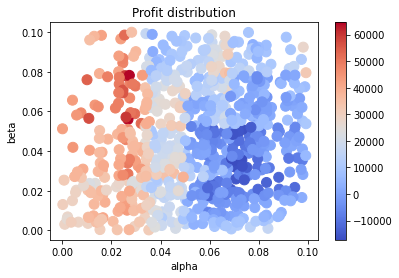

"\ncolors = [x for x in results]\nplt.scatter(z_scatter, w_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)\nplt.colorbar()\nplt.xlabel('moving average')\nplt.ylabel('trend lenth')\nplt.title('Profit distribution')\nplt.show()\n\n\ncolors = [x for x in results]\nplt.scatter(x_scatter, z_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)\nplt.colorbar()\nplt.xlabel('alpha')\nplt.ylabel('moving average')\nplt.title('Profit distribution')\nplt.show()\n\n\ncolors = [x for x in results]\nplt.scatter(y_scatter, z_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)\nplt.colorbar()\nplt.xlabel('beta')\nplt.ylabel('moving average')\nplt.title('Profit distribution')\nplt.show()\n"

In [75]:
x_scatter = [results[x][0] for x in results] # alpha
y_scatter = [results[x][1] for x in results] # beta
# z_scatter = [results[x][2] for x in results] # moving average
# w_scatter = [results[x][3] for x in results] # trend lenth

marker_size = 100
colors = [x for x in results]
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Profit distribution')
plt.show()

"""
colors = [x for x in results]
plt.scatter(z_scatter, w_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('moving average')
plt.ylabel('trend lenth')
plt.title('Profit distribution')
plt.show()


colors = [x for x in results]
plt.scatter(x_scatter, z_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('alpha')
plt.ylabel('moving average')
plt.title('Profit distribution')
plt.show()


colors = [x for x in results]
plt.scatter(y_scatter, z_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('beta')
plt.ylabel('moving average')
plt.title('Profit distribution')
plt.show()
"""

In [ ]:
trends = find_decreasing_trend_lines(data, 2, 7)
pos = findOpenPositionIndexes(trends)

prof = 0
money = 100000
bI = 0
for i in pos:
    mon, profit, boughtIndex = findClosePosition(i, money, bI, 0.0267, 0.0559, data.shape[0])
    money = mon
    bI = boughtIndex
    prof += profit

In [87]:
low = data["<LOW>"]
close = data["<CLOSE>"]
high = data["<HIGH>"]

In [92]:
resistances = l.find_resistance(data)
res_arr = [index[0] for index in resistances]

In [93]:
def findLastIndex(trendIndex):
    index = 0
    while (res_arr[index] < trendIndex) and (index+1 < len(res_arr)):
        index += 1
    return index-1

In [94]:
def findOpenBuyPositionIndexes(trends):
    openPositionIndexes = []
    for trend in trends:
        trendStart = trend[2]
        lastResistance = findLastIndex(trendStart)
        resHigh = high[res_arr[lastResistance]] # supLow
        if resHigh < high[trendStart]:
            #print("Pass")
            pass
        else:
            for index in range (trendStart, trendStart+10):
                if resHigh < high[index]:
                    # Пробитие сопротивления
                    # print(f"Open position, {supLow, low[i], trendStart, index}")
                    if len(openPositionIndexes) == 0:
                        openPositionIndexes.append(index)
                        break
                    if index > openPositionIndexes[-1]:
                        openPositionIndexes.append(index)
                        break
  
    return openPositionIndexes

In [107]:
def findCloseBuyPosition(openIndex, money, boughtIndex, alpha, beta, lenth):
    #print(f"Open index: {openIndex}, Price: {close[openIndex]}")
    if boughtIndex > openIndex:
        return (money, 0, boughtIndex)
    index = openIndex
    openPrice = close[openIndex]
    sharesBought = money // openPrice
    rest = money - (openPrice * sharesBought)
    while (openPrice/close[index] > (1-alpha)) and (openPrice/close[index] < (1+beta)):
        if lenth-1 > index:
            index += 1
        else:
            break
    profit = round(sharesBought*close[index] - sharesBought*openPrice, 2)
    money = profit + money + rest
    # print(sharesBought, money, profit)
    # print(f"Profit: {profit}")
    # print(f"Buy position. Open price: {openPrice}, close price: {close[index]}, , start/end indexes: {openIndex, index}")
    return (money, profit, index)

In [ ]:
trends = find_rising_trend_lines(data, 4, 5)
pos = findOpenBuyPositionIndexes(trends)

prof = 0
money = 100000
bI = 0
for i in pos:
    mon, profit, boughtIndex = findCloseBuyPosition(i, money, bI, 0.0267, 0.0559, data.shape[0])
    money = mon
    bI = boughtIndex
    prof += profit

In [119]:
alphas = [0, 0.1]
betas = [0, 0.1]
trends = find_rising_trend_lines(data, 4, 5)
pos = findOpenBuyPositionIndexes(trends)
results = {}

for iter in range (2048):
    alpha = np.random.uniform(alphas[0], alphas[1])
    beta = np.random.uniform(betas[0], betas[1])
    # print(f"Iter: {iter}, coefs: {alpha, beta}")

    prof = 0
    money = 100000
    bI = 0
    for i in pos:
        mon, profit, boughtIndex = findCloseBuyPosition(i, money, bI, alpha, beta, data.shape[0])
        money = mon
        bI = boughtIndex
        prof += profit
    # results[prof] = (alpha, beta, movingAverage, trendLenth)
    results[prof] = (alpha, beta)
print(f"Max profit: {max(results)} was received by alpha and beta: {results[max(results)]}")

Max profit: 142973.76999999996 was received by alpha and beta: (0.09971603056366032, 0.02626573248332137)


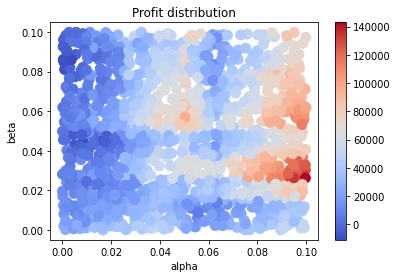

In [120]:
x_scatter = [results[x][0] for x in results] # alpha
y_scatter = [results[x][1] for x in results] # beta
# z_scatter = [results[x][2] for x in results] # moving average
# w_scatter = [results[x][3] for x in results] # trend lenth

marker_size = 100
colors = [x for x in results]
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Profit distribution')
plt.show()

In [123]:
a = [1,2,9]
b = [2,2,3]
sorted(a+b)

[1, 2, 2, 2, 3, 9]

In [142]:
trendsBuy = find_rising_trend_lines(data, 4, 5)
indexesBuy = findOpenBuyPositionIndexes(trendsBuy)
buyDict = {i:"Buy" for i in indexesBuy}
trendsSell = find_decreasing_trend_lines(data, 4, 5)
indexesSell = findOpenPositionIndexes(trendsSell)
sellDict = {i:"Sell" for i in indexesSell}
useDict = {**buyDict, **sellDict}

In [157]:
def openRightPosition(index, position, money, curIndex, aS, bS, aB, bB):
    if position == "Sell":
        money, profit, closeIndex = findClosePosition(index, money, curIndex, aS, bS, data.shape[0])
        return (money, profit, closeIndex)
    else:
        money, profit, closeIndex = findCloseBuyPosition(index, money, curIndex, aB, bB, data.shape[0])
        return (money, profit, closeIndex)

In [158]:
alphasSell = [0, 0.2]
betasSell = [0, 0.2]
alphasBuy = [0, 0.2]
betasBuy = [0, 0.2]
trends = find_rising_trend_lines(data, 4, 5)
pos = findOpenBuyPositionIndexes(trends)
results = {}

for iter in range (1024):
    alphaSell = np.random.uniform(alphasSell[0], alphasSell[1])
    betaSell = np.random.uniform(betasSell[0], betasSell[1])
    alphaBuy = np.random.uniform(alphasBuy[0], alphasBuy[1])
    betaBuy = np.random.uniform(betasBuy[0], betasBuy[1])
    print(f"Iter: {iter}, coefs: {alphaSell, betaSell, alphaBuy, betaBuy}")

    profit = 0
    money = 100000
    currentIndex = 0
    for index in sorted(useDict):
        currentMoney, currentProfit, closeIndex = openRightPosition(index, useDict[index], money, currentIndex,
                                                                    alphaSell, betaSell, alphaBuy, betaBuy)
        money = currentMoney
        profit += currentProfit
        currentIndex = closeIndex
    results[profit] = (alphaSell, betaSell, alphaBuy, betaBuy)
print(f"Max profit: {max(results)} was received by alpha and beta: {results[max(results)]}")

Iter: 0, coefs: (0.17052261016372058, 0.13267122558461864, 0.040959964590982195, 0.11321313590928894)
Iter: 1, coefs: (0.0009726840248226676, 0.1339043695596608, 0.1732528854871008, 0.18976661651507687)
Iter: 2, coefs: (0.07374313900023757, 0.06715551368525352, 0.09092952407966787, 0.12574351362893954)
Iter: 3, coefs: (0.12524007415407393, 0.07701066737202421, 0.06654354824633942, 0.1261443308442979)
Iter: 4, coefs: (0.13657152891115684, 0.12485048124531589, 0.018512892544823047, 0.1780526506947024)
Iter: 5, coefs: (0.12604491653918465, 0.03976741886223883, 0.06821763039185406, 0.09741003161922762)
Iter: 6, coefs: (0.0672578559377841, 0.13703684742833877, 0.0493341354659155, 0.11769747054197709)
Iter: 7, coefs: (0.05960903052833011, 0.17810260462969413, 0.07094760964426731, 0.19389688191225868)
Iter: 8, coefs: (0.03069615486465607, 0.09504187777611497, 0.16305187124226483, 0.17967778551419908)
Iter: 9, coefs: (0.08515088059186288, 0.14648605462972517, 0.09185292221499837, 0.02273062545

In [154]:
profit = 0
money = 100000
currentIndex = 0
for index in sorted(useDict):
    currentMoney, currentProfit, closeIndex = openRightPosition(index, useDict[index], money, currentIndex)
    money = currentMoney
    profit += currentProfit
    currentIndex = closeIndex

Buy
Money: 105723.43999999999, profit: 5612.04
Sell
Money: 109587.29999999999, profit: 3784.71
Buy
Money: 109587.29999999999, profit: 0
Sell
Money: 113565.59999999999, profit: 3849.86
Buy
Money: 108348.90999999999, profit: -5232.7
Sell
Money: 104733.65999999997, profit: -3647.27
Buy
Money: 100832.21999999994, profit: -3976.98
Buy
Money: 94856.5749999999, profit: -6049.7
Buy
Money: 90507.08999999978, profit: -4367.52
Sell
Money: 93699.69999999958, profit: 3073.66
Buy
Money: 97376.71999999916, profit: 3566.16
Sell
Money: 93955.13999999831, profit: -3430.08
Buy
Money: 97342.59999999662, profit: 3328.42
Sell
Money: 93548.02999999323, profit: -3920.22
Buy
Money: 93548.02999999323, profit: 0
Buy
Money: 99158.45999998647, profit: 5521.6
Buy
Money: 104356.05999997293, profit: 5145.98
Buy
Money: 104356.05999997293, profit: 0
Buy
Money: 109103.71999994587, profit: 4700.97
Sell
Money: 105311.63999989175, profit: -3887.4
Buy
Money: 105311.63999989175, profit: 0
Buy
Money: 105311.63999989175, profi